In [42]:
# AI & Basic Data Science class classification assignment
# Using Kaggle data to determine whether a loan will be defaulted
# Task details:
# 1) EDA with y-data profiling
# 2) Handling imbalanced data
# 3) Compare ensemble methods
# 4) Discuss classification report
# 5) Discuss three questions/hypothesis given in the class

# I used the following for handling imbalanced data
# https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html
# https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set/answers/1144228?srid=h3G6o

In [ ]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

C:\Users\makmu\AppData\Local\Temp\ipykernel_15664\2573425609.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
#EDA tool
from ydata_profiling import ProfileReport

In [3]:
# data processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [4]:
# handling imbalanced data using ADASYN
from imblearn.over_sampling import ADASYN

In [5]:
# for data spliting, model evaluation, optimization
from sklearn.model_selection import train_test_split,KFold,cross_val_score

In [6]:
# compare the models. 
# ensemble models
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

In [43]:
# report generation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import PartialDependenceDisplay as pdd
# https://www.kaggle.com/code/dansbecker/partial-dependence-plots

Questions/Hypothesis:<br>
* The higher the installment the more likely to default
* Individual vs Join application (application_type), which one is more likely to default?
* The higher the credit limit the more likely to default

In [9]:
# date & time
from datetime import datetime
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
# convert datetime obj to string
str_current_datetime = str(current_datetime)

In [5]:
# read data
path = "C:\\Temp\\handson\\datasets\\"

def readfile(filename,path):
    file = path + filename
    return pd.read_csv(file,low_memory=False)

filename = 'alllendingloans_train.csv'
dataset = readfile(filename,path)

In [11]:
# data shape
dataset.shape

(66338, 150)

In [12]:
# data details
dataset.info

<bound method DataFrame.info of               id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0      130956066       3000         3000           3000.0   36 months   
1      130968727       5000         5000           5000.0   36 months   
2      130910225       7000         7000           7000.0   36 months   
3      130966492      30000        30000          30000.0   36 months   
4      130942737      21000        21000          21000.0   60 months   
...          ...        ...          ...              ...         ...   
66333  102395624      35000        35000          35000.0   60 months   
66334  102426796      12000        12000          12000.0   60 months   
66335  102556443      24000        24000          24000.0   60 months   
66336  102196576       6000         6000           6000.0   36 months   
66337   99799684      30000        30000          30000.0   60 months   

       int_rate  installment grade sub_grade              emp_title  ...  \
0          7.34

In [13]:
# data detail trapose to see more summarized
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
id,66338.0,1.176530e+08,1.080559e+07,687119.00,1.100361e+08,1.150952e+08,1.271891e+08,1.411120e+08
loan_amnt,66338.0,1.435991e+04,9.654039e+03,1000.00,7.000000e+03,1.200000e+04,2.000000e+04,4.000000e+04
funded_amnt,66338.0,1.435991e+04,9.654039e+03,1000.00,7.000000e+03,1.200000e+04,2.000000e+04,4.000000e+04
funded_amnt_inv,66338.0,1.435604e+04,9.651565e+03,1000.00,7.000000e+03,1.200000e+04,2.000000e+04,4.000000e+04
int_rate,66338.0,1.374191e+01,5.589039e+00,5.31,9.930000e+00,1.274000e+01,1.602000e+01,3.099000e+01
...,...,...,...,...,...,...,...,...
hardship_payoff_balance_amount,301.0,1.577412e+04,9.449370e+03,1480.13,8.067150e+03,1.407723e+04,2.238634e+04,3.954245e+04
hardship_last_payment_amount,301.0,2.366184e+02,2.546723e+02,0.01,4.215000e+01,1.506500e+02,3.408600e+02,1.283900e+03
settlement_amount,1237.0,6.313451e+03,4.440902e+03,331.44,2.950360e+03,5.210000e+03,8.540570e+03,2.579000e+04
settlement_percentage,1237.0,5.027108e+01,7.764855e+00,29.95,4.500000e+01,4.999000e+01,5.500000e+01,8.000000e+01


In [6]:
# prepare the classification target
# based on the value of the loan_status column: Fully Paid & Charged Off
pd.set_option('display.width',100)
dataset.head(5)
# function so I can call many time in case I will be using many/split datasets
def set_target(dataset):
    dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid','Charged Off'])]
    dataset['charged_off']=(dataset['loan_status']=='Charged Off').apply(np.uint8)
    dataset.drop('loan_status',axis=1,inplace=True)
    return dataset

dataset=set_target(dataset)

In [7]:
# I use y-data profiling for EDA (https://docs.profiling.ydata.ai/latest/)
# Generate the report
profile = ProfileReport(dataset,title="Loans Profile")
# Save the report to .html
profile.to_file("Loans_EDA_report.html")

Summarize dataset:  97%|█████████▋| 152/157 [00:07<00:00, 21.93it/s, Calculate auto correlation]                                  c:\Projects\handson\Lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'WA'')
  warnings.warn(
Summarize dataset: 100%|█████████▉| 11180/11185 [17:16<00:02,  1.98it/s, Missing diagram heatmap]                                                                       c:\Projects\handson\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + 

y-data profiling produced a profile report in HTML with a size of about 600,000 KB. It is a very big report, through and details!. After reviewing these reports I proceed with the following steps.

In [15]:
# data cleaning & feature selection 
# This function will execute actions based on the result this EDA
# 1. remove columns (such as too many missing values, etc)
# 2. combine columns/new features and remove old ones
# 3. remove columns having low/zero correlation with the target
def data_prep(dataset):
    drop_cols= {
                'funded_amnt', # numerical
                'funded_amnt_inv',
                'desc',
                'out_prncp',
                'out_prncp_inv',
                'next_pymnt_d',
                'mths_since_last_major_derog',
                'annual_inc_joint',
                'dti_joint',
                'mths_since_recent_bc_dlq',
                'mths_since_recent_revol_delinq',
                'revol_bal_joint',
                'sec_app_fico_range_low',
                'sec_app_fico_range_high',
                'sec_app_inq_last_6mths',
                'sec_app_mort_acc',
                'sec_app_open_acc',
                'sec_app_revol_util',
                'sec_app_open_act_il',
                'sec_app_num_rev_accts',
                'sec_app_chargeoff_within_12_mths',
                'sec_app_collections_12_mths_ex_med',
                'sec_app_mths_since_last_major_derog',
                'deferral_term',
                'hardship_amount',
                'hardship_length',
                'hardship_dpd',
                'orig_projected_additional_accrued_interest',
                'hardship_payoff_balance_amount',
                'hardship_last_payment_amount',
                'settlement_amount',
                'settlement_percentage',
                'settlement_term',
                'pymnt_plan', # obj
                'url',
                'verification_status_joint',
                'sec_app_earliest_cr_line',
                'hardship_flag',
                'hardship_type',
                'hardship_reason',
                'hardship_status',
                'hardship_start_date',
                'hardship_end_date',
                'payment_plan_start_date',
                'hardship_loan_status',
                'debt_settlement_flag_date',
                'settlement_status',
                'settlement_date',
                'emp_length'
                }
    dataset.drop(labels=drop_cols,axis=1,inplace=True)
    # create combined new features
    dataset['fico_range_comb']=0.5*dataset['fico_range_low'] + 0.5*dataset['fico_range_high']
    dataset['pymnt_inv_comb']=0.5*dataset['total_pymnt'] + 0.5*dataset['total_pymnt_inv']
    dataset['last_fico_range_comb']=0.5*dataset['last_fico_range_high'] + 0.5*dataset['last_fico_range_low']
    dataset['open_inq_comb']=0.5*dataset['open_act_il'] + 0.5*dataset['inq_last_12m']
    # remove features that are combined
    drop_comb = {
                'fico_range_low',
                'fico_range_high',
                'total_pymnt',
                'total_pymnt_inv',
                'last_fico_range_high',
                'last_fico_range_low',
                'open_act_il',
                'inq_last_12m'
                }
    dataset.drop(labels=drop_comb,axis=1,inplace=True)
    # drop as zero correlation
    dataset.drop('num_actv_rev_tl',axis=1,inplace=True)
    return dataset

In [16]:
# execute dataset preparation
dataset=data_prep(dataset)

In [17]:
# check if any null values
dataset.isnull().values.any()

True

The data still contains null values. I need to handle them later.

In [18]:
# I have cleaned the data but there certain columns with outliers (extreme values)
# these outliers can significantly impact statistical analyses and machine learning models
# these outliers can be visualized in y-data profiling, but we can visualize with details
# the following is based on this article:
# https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

outliers_cols = {
                  'annual_inc',
                  'dti',
                  'revol_bal',
                  'tot_cur_bal',
                  'total_bal_il',
                  'total_rev_hi_lim',
                  'tot_hi_cred_lim',
                  'total_bal_ex_mort'
                  }

In [19]:
# Visualization of outliers/extreme values
def plot_extvals(dataset):
    fig, axes = plt.subplots(len(outliers_cols), 2, figsize=(8, 10))
    i=0
    for col in outliers_cols:
        fig.suptitle('Features with outliers/extreme')
        sns.histplot(ax=axes[i,0],data=dataset,x=col,kde=True)
        sns.boxplot(ax=axes[i,1], data=dataset,x=col)
        fig.tight_layout()
        i=i+1
    plt.show()

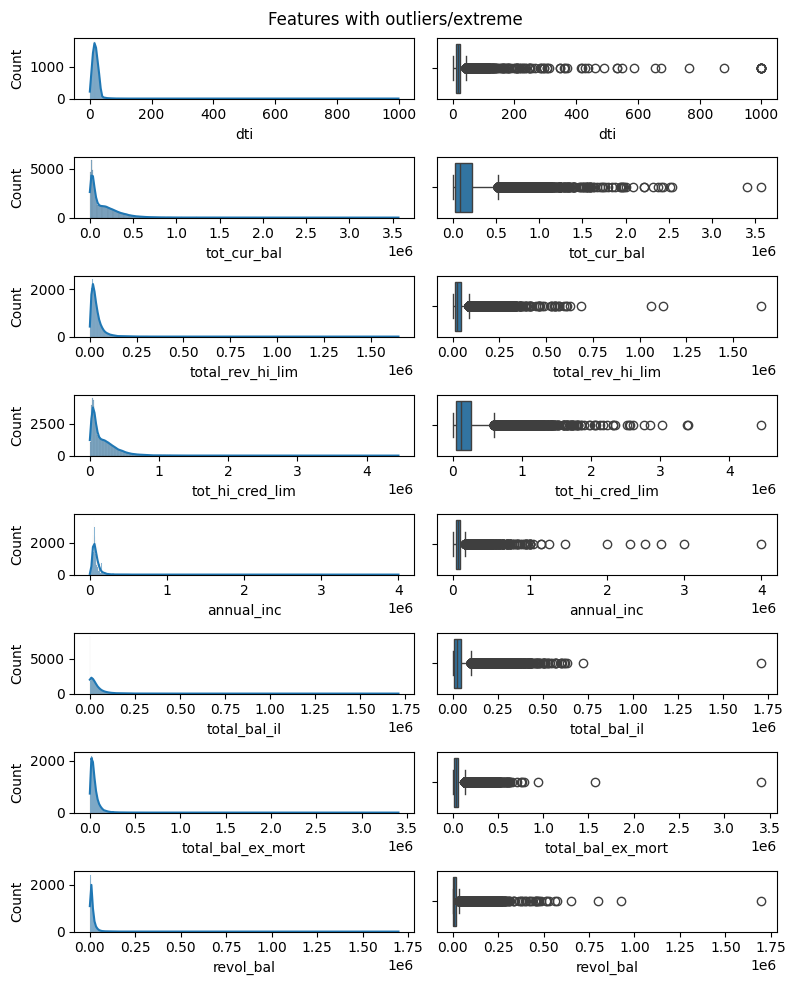

In [20]:
plot_extvals(dataset)

While most valules are near zero, Some values/outliers as high as multiply of 1000000 (1e6).

In [21]:
# data transformation
# 1) transform outliers/extreme values using logaritmic
def extrem_transf(dataset):
    for col in outliers_cols:
        dataset[col] = np.log(dataset[col])
    return dataset

In [22]:
# execute outliers transformation
dataset=extrem_transf(dataset)

c:\Projects\handson\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


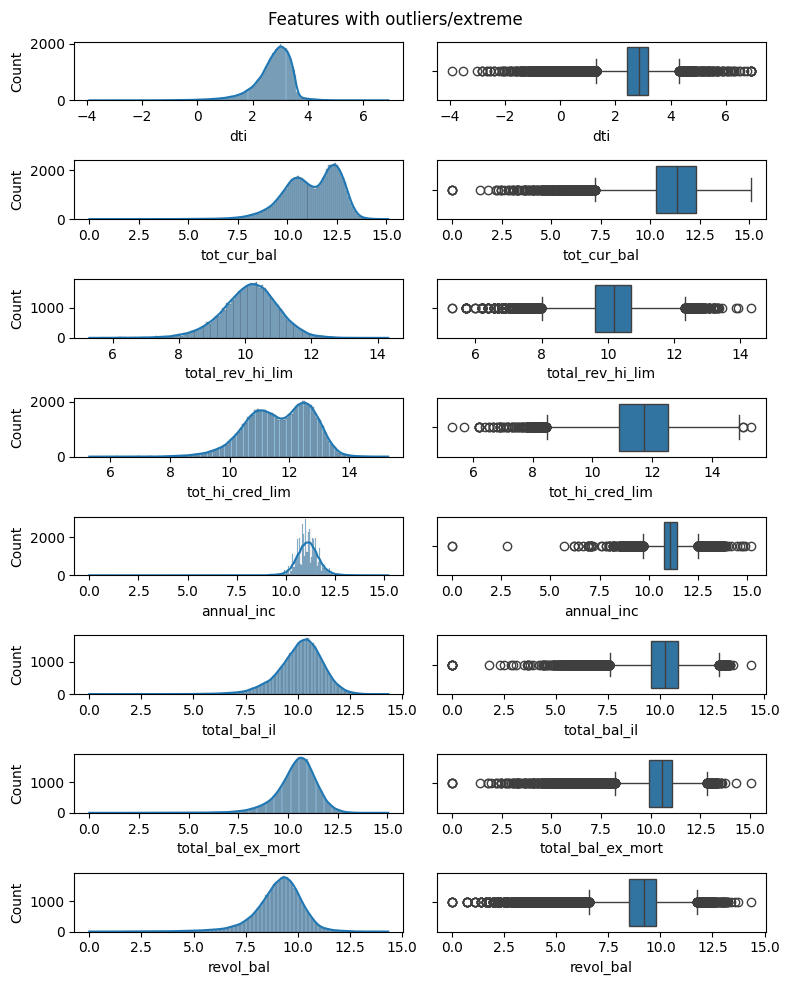

In [23]:
# now if I plot again. no more extreme values!
plot_extvals(dataset)

In [24]:
# I have transformed the outliers/extreme
# now I will (1) encode object column (labelendocer)
#            (2) scale numeric column (standard)
def data_transf(dataset):
    # objects columns
    categorical_feature_mask=dataset.dtypes==object
    categorical_cols=dataset.columns[categorical_feature_mask].tolist()
    for col in categorical_cols:
        dataset[col].fillna(dataset[col].mode().iloc[0],inplace=True) # replace with the most frequent value for categoricals
    label_encoder = LabelEncoder()
    dataset = dataset.copy()
    dataset = dataset.rename(columns=lambda x: x.strip())
    for col in categorical_cols:
        dataset[col]=label_encoder.fit_transform(dataset[col])

    # numerical columns
    # first replace nan & infinity with 0
    dataset = dataset.replace([np.nan, -np.inf], 0)
    
    numerical_cols = [x for x in dataset.columns.values[1:] if x not in categorical_cols]
    if 'charged_off' in numerical_cols:
        numerical_cols.remove('charged_off')
    dataset[numerical_cols].fillna(dataset.mean().iloc[0]) # replace with the mean value for numericals
    scaler = StandardScaler()
    dataset[numerical_cols] = scaler.fit_transform(dataset[numerical_cols])

    return dataset

In [25]:
# execute data transform
dataset=data_transf(dataset)

In [26]:
# check if any null values
dataset.isnull().values.any()

False

At this step, there is no null values in the data. Because, I've done the following at the previous step.<br>
    * I replace them with the most frequent value for categoricals<br>
    * I replace them with the mean value for numericals <br>
In real situation, I will discuss with business/other stake holders to understand better and provide appropriate treatment to these null values.

In [27]:
# preparing target & predictors
ncols=len(dataset.columns)
dataset=dataset.iloc[:,1:ncols]
# assign target & predictor
Y=dataset['charged_off'] # target
X=dataset.loc[:,dataset.columns != 'charged_off'] # predictors

In [28]:
# lets see the distribution of target values
Y.value_counts()

charged_off
0    52302
1    14036
Name: count, dtype: int64

In [29]:
# this is very imbalanced data, I will use ADASYN to handle this. ADASYN is adaptive.
# instead of all the sample being linearly interpolated (SMOTE)
# it adds a random small values to the points thus making it more realistic
seed = 42
ada = ADASYN(random_state=seed)
X_ada,Y_ada = ada.fit_resample(X,Y)

In [30]:
# lets see the distribution of target values after ADASYN
Y_ada.value_counts()

charged_off
1    54368
0    52302
Name: count, dtype: int64

In [31]:
# performing the train test and validation split
train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10
# performing train test split
x_train, x_test, y_train, y_test = train_test_split(X_ada, Y_ada, test_size=1 - train_ratio)
# performing test validation split
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

In [32]:
#test options
num_folds=10
scoring = 'roc_auc'
#selected models & cross validation execution
models = []
#models.append(('DART', DecisionTreeClassifier()))
# ensemble
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# bagging
models.append(('RF', RandomForestClassifier()))
# additional models can be added
# results
results =[]
names = []
entries = [] # seaborn
dfresults = pd.DataFrame(index=range(num_folds * len(models)))
best_model = ""
best_name = ""
best_score = 0
# looping all the models
for name, model in models:    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(msg)
    if cv_results.mean() > best_score:
        best_model=model
        best_name=name
        best_score=cv_results.mean()
    for fold_idx, result in enumerate(cv_results): # for seaborn
        entries.append((name,fold_idx,result))
        dfresults = pd.DataFrame(entries,columns=['Models','fold_idx','Score'])
print("best model:",best_model)

AB: 0.999944 (0.000052)
GBM: 0.999923 (0.000092)
RF: 0.999967 (0.000058)
best model: RandomForestClassifier()


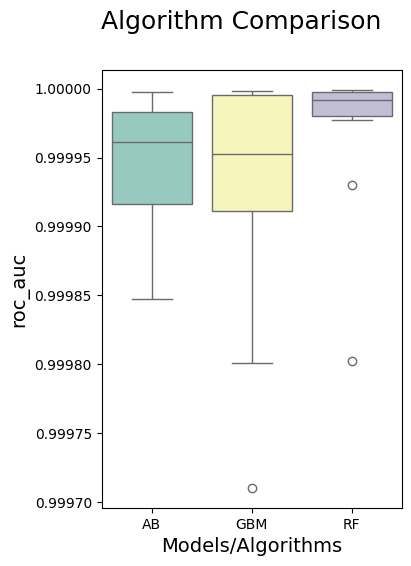

In [33]:
# compare results
# use seaborn
fig = plt.figure()
fig.suptitle('Algorithm Comparison',fontsize=18)
#ax = fig.add_subplot(111) # 111?
fig.set_size_inches(len(models)+1,6) # length height
sns.boxplot(x = 'Models', y = 'Score', data = dfresults, palette = "Set3")
plt.subplots_adjust(bottom=.15, left=.15)
plt.xlabel("Models/Algorithms",fontsize=14)
plt.ylabel(scoring,fontsize=14)
plt.show()

Among these 3 models, RF produces the best roc_auc score.

In [34]:
# Use best_model to predict
model = best_model # the best model/algorithm
model.fit(x_train,y_train)
# estimate accuracy on validation set
predictions = model.predict(x_val)
accuracy_score(y_val,predictions)

0.9993437705071716

In [35]:
# display classification report
print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10414
           1       1.00      1.00      1.00     10920

    accuracy                           1.00     21334
   macro avg       1.00      1.00      1.00     21334
weighted avg       1.00      1.00      1.00     21334



Wow.. the classification report shows perfect score. In theory, this model predicts with almost 100% accurate! but what if it is used to predict unseen data?
Next time, I will split/create unseen data from the dataset to see the performance in unseen data, whether or no overfitting occurs?

In [36]:
# Confusion matrix
stitle=""
class_names = ['Fully Paid', 'Charged Off']
# plot confusion matrix
def plot_confusion_matrix(predictions,Y_validation,stitle):
    matrix = confusion_matrix(Y_validation,predictions)
    plt.set_size_inches=(6*len(class_names),6)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2)
    # Add labels to the plot
    tick_marks = np.arange(len(class_names))+0.5
    plt.xticks(tick_marks, class_names, rotation=30)
    plt.yticks(tick_marks, class_names, rotation=0)
    plt.subplots_adjust(bottom=.20, left=.20)
    plt.xlabel('Predicted',fontsize=14)
    plt.ylabel('Actual',fontsize=14)
    plt.title(stitle)
    plt.show()

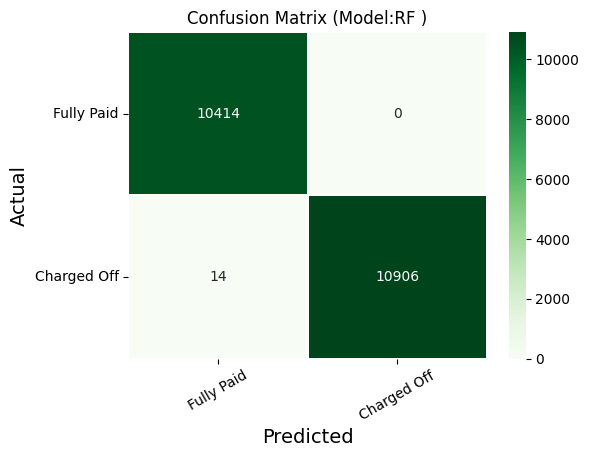

In [37]:
stitle="Confusion Matrix (Model:"+best_name+" )"
plot_confusion_matrix(predictions,y_val,stitle)

Confusion Matrix:
Positive class is charged off (defaulted). Negative class if fully paid.
False Positive: 0 vs  True Positive: 10906. The model has zero mistake in identifying the charged off. It doesnt identify any 'fully paid' as 'charged off'.
False Negative: 14 vs True Negative: 10414. However, the model has missed charged off although in small number.
Again in theory, this is good result

In [38]:
# df.nlargest(3, 'Client')
def plot_feature_importance(importance,names,model, number_features):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    #Sort the DataFrame in order decreasing feature importance
    #fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.nlargest(number_features,'feature_importance')
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    ptitle='FEATURE IMPORTANCE %s' % (model)
    plt.title(ptitle)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.subplots_adjust(bottom=.20, left=.20)
    plt.show()

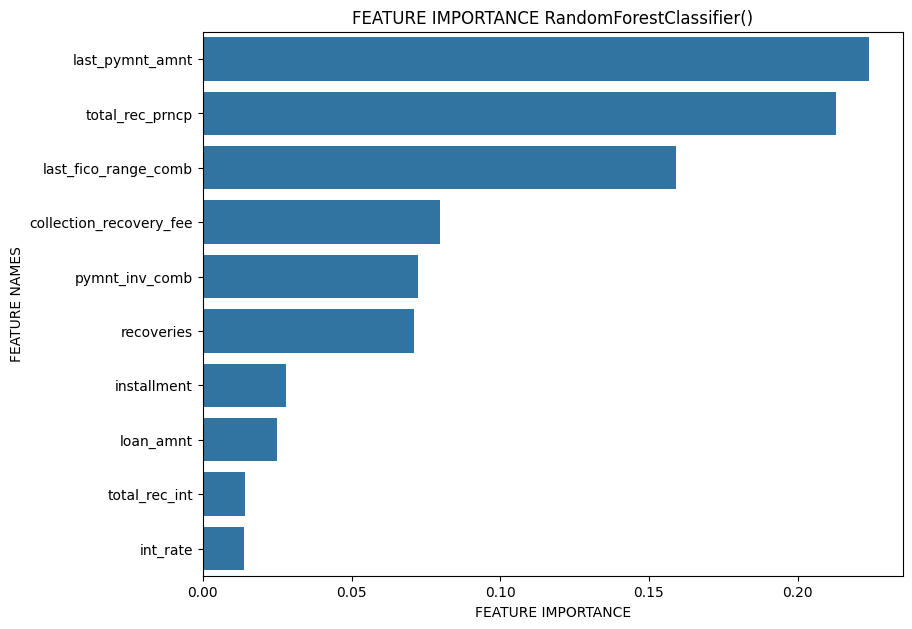

In [39]:
plot_feature_importance(model.feature_importances_,X.columns,model,10)

This shows 10 most important factors for this prediction. Some of these features intuitively tell us that it is major factor such as last payment amount, installment size and loan amount.

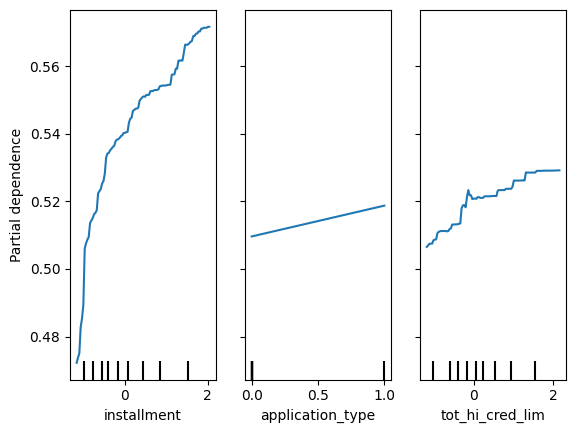

In [53]:
factors_colns = ['installment', 'application_type', 'tot_hi_cred_lim']
pdd.from_estimator(model, x_train, range(3), feature_names=factors_colns)

To answer the questions/hypothesis asked in the assignment:
Partial dependence plots show how each variable or predictor affects the model's predictions.
1). The higher the installment, the more likely the customer will not able to fully pay. This makes sense, but to be more contextual probably we could analize the data more details such as comparing with the income.
2). Join application seems more likely to default. Perhaps, they are unfortunately separated/divorced? or they pass the responsibility to each other?
3). High credit customer more likely to default. Again, we need to check more data to conclude, but probably higher credit limit will loan higher amount, resulted for them not able to pay.